100%|██████████| 10/10 [00:00<00:00, 14.71it/s]


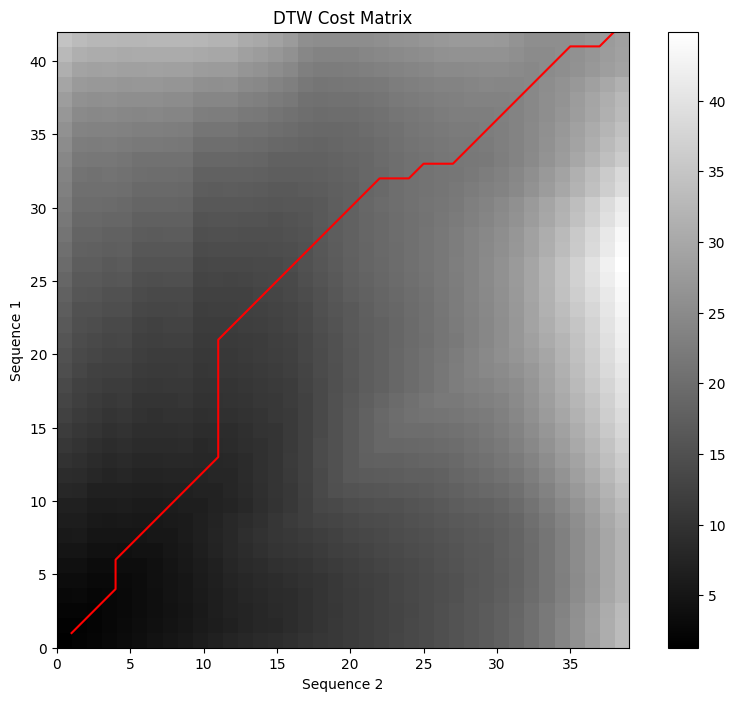

In [6]:
import os
import numpy as np
from tqdm import tqdm
import wave
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import librosa

sample_rate = 44100
win_len = 1024
win_shift = int(win_len / 3)
win_type = 'hanning'
sigma = 1

def read_data(directory):
    audios = []
    labels = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                label = int(file.split('_')[0])
                labels.append(label)
                
                file_path = os.path.join(root, file)
                
                # Load audio file with librosa
                audio_data, sr = librosa.load(file_path, sr=sample_rate)

                # Trim silence from the beginning and end
                audio_data, _ = librosa.effects.trim(audio_data, top_db=20)

                n_frames = len(audio_data)
                audios.append((audio_data, n_frames))

    labels = np.array(labels)
    return audios, labels

def framing(wave_data, nframes):
    win_num = int(np.ceil(1 + (nframes - win_len) / win_shift))
    frames = np.zeros([win_num, win_len])

    for i in range(win_num):
        if i * win_shift + win_len <= nframes:
            frames[i, :] = wave_data[i * win_shift:i * win_shift + win_len]
        else:
            frames[i, :nframes - i * win_shift] = wave_data[i * win_shift:nframes]

    window = np.ones(win_len)

    if win_type == 'hanning':
        window = np.hanning(win_len)
    elif win_type == 'hamming':
        window = np.hamming(win_len)

    for i in range(win_num):
        frames[i, :] = window * frames[i, :]

    return frames

def pre_emphasis(signal, a=0.97):
    return np.append(signal[0], signal[1:] - a * signal[:-1])

def preprocess(signals):
    all_frames = []
    for wave_data, nframes in signals:
        emphasized_signal = pre_emphasis(wave_data)
        frames = framing(emphasized_signal, nframes)
        all_frames.append(frames)
    return all_frames

def compute_fft(frames):
    return [np.fft.rfft(frame, n=frame.shape[1], axis=1) for frame in frames]

def compute_spectral_energy(fft_frames):
    return [np.abs(frame) ** 2 for frame in fft_frames]

def mel_filter_bank(num_filters, fft_size, sample_rate):
    low_freq_mel = 0
    high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
    mel_points = np.linspace(low_freq_mel, high_freq_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin_points = np.floor((fft_size // 2 + 1) * hz_points / sample_rate).astype(int)

    filters = np.zeros((num_filters, int(fft_size // 2 + 1)))
    for m in range(1, num_filters + 1):
        f_m_minus = int(bin_points[m - 1])
        f_m = int(bin_points[m])
        f_m_plus = int(bin_points[m + 1])

        for k in range(f_m_minus, f_m):
            filters[m - 1, k] = (k - bin_points[m - 1]) / (bin_points[m] - bin_points[m - 1])
        for k in range(f_m, f_m_plus):
            filters[m - 1, k] = (bin_points[m + 1] - k) / (bin_points[m + 1] - bin_points[m])

    return filters

def compute_mfcc(spectral_energy, sample_rate, num_filters=40, num_ceps=12):
    mfccs = []
    for energy in spectral_energy:
        fft_size = (energy.shape[-1] - 1) * 2
        mel_filters = mel_filter_bank(num_filters, fft_size, sample_rate)
        mel_energy = np.tensordot(energy, mel_filters.T, axes=([-1], [0]))
        mel_energy = np.where(mel_energy == 0, np.finfo(float).eps, mel_energy)
        log_mel_energy = np.log(mel_energy)
        mfcc = dct(log_mel_energy, type=2, axis=-1, norm='ortho')[..., :num_ceps]
        mfccs.append(mfcc)
    return mfccs

def euclidean_distance(x, y):
    return (1 / x.size) * np.sqrt(np.sum((x - y) ** 2))

def dtw(s1, s2):
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n, m), np.inf)
    dtw_matrix[0, 0] = euclidean_distance(s1[0], s2[0])

    for i in range(1, n):
        dtw_matrix[i, 0] = dtw_matrix[i-1, 0] + euclidean_distance(s1[i], s2[0])
    for j in range(1, m):
        dtw_matrix[0, j] = dtw_matrix[0, j-1] + euclidean_distance(s1[0], s2[j])

    for i in range(1, n):
        for j in range(1, m):
            cost = euclidean_distance(s1[i], s2[j])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # Insertion
                                          dtw_matrix[i, j-1],    # Deletion
                                          dtw_matrix[i-1, j-1])  # Match

    return dtw_matrix

def plot_dtw(s1, s2, dtw_matrix, path):
    plt.figure(figsize=(10, 8))
    # 使用 extent 参数调整显示范围
    plt.imshow(dtw_matrix[1:, 1:], origin='lower', cmap='gray', interpolation='nearest', extent=(0, len(s2), 0, len(s1)))
    plt.colorbar()
    plt.title('DTW Cost Matrix')
    plt.xlabel('Sequence 2')
    plt.ylabel('Sequence 1')
    # 绘制路径时，考虑路径坐标偏移
    plt.plot(path[:, 1] + 1, path[:, 0] + 1, 'r')  # 路径坐标加1
    plt.show()

def compute_dtw_path(dtw_matrix):
    n, m = dtw_matrix.shape
    path = []
    i, j = n - 1, m - 1
    path.append((i, j))

    while i > 0 or j > 0:
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            steps = np.array([dtw_matrix[i-1, j-1], dtw_matrix[i-1, j], dtw_matrix[i, j-1]])
            step_index = np.argmin(steps)
            if step_index == 0:
                i, j = i-1, j-1
            elif step_index == 1:
                i -= 1
            else:
                j -= 1
        path.append((i, j))

    path.reverse()
    return np.array(path)

def compute_dtw_distance(templates, tests):
    num_templates = len(templates)
    num_tests = len(tests)
    distance_matrix = np.zeros((num_templates, num_tests))

    for i in tqdm(range(num_templates)):
        for j in range(num_tests):
            s1 = templates[i]
            s2 = tests[j]
            
            # Compute DTW
            dtw_matrix = dtw(s1, s2)
            
            # Calculate DTW distance
            distance = dtw_matrix[-1, -1]
            distance_matrix[i, j] = distance
    
    return distance_matrix

def plot_distance_matrix(distance_matrix):
    plt.figure(figsize=(10, 8))
    plt.imshow(distance_matrix, interpolation='nearest', cmap='hot', aspect='auto')
    plt.title("DTW Distance Matrix Heatmap")
    plt.xlabel("Test Samples")
    plt.ylabel("Template Samples")
    plt.colorbar(label='DTW Distance')
    plt.show()

def calculate_accuracy(distance_matrix, template_labels, test_labels):
    # Predict labels based on the nearest neighbor in the template set
    num_tests = distance_matrix.shape[1]
    correct_predictions = 0

    for j in range(num_tests):
        # Find the index of the minimum distance for each test sample
        min_index = np.argmin(distance_matrix[:, j])
        predicted_label = template_labels[min_index]
        
        # Check if the predicted label matches the actual label
        if predicted_label == test_labels[j]:
            correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / num_tests
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")
    return accuracy

templates_directory = 'dtw_4_plot/template'
test_directory = 'dtw_4_plot/test'
templates_audios, templates_labels = read_data(templates_directory)
test_audios, test_labels = read_data(test_directory)
# Process and calculate as before
templates_frames = preprocess(templates_audios)
test_frames = preprocess(test_audios)
X_temp = compute_fft(templates_frames)
X_test = compute_fft(test_frames)
E_temp = compute_spectral_energy(X_temp)
E_test = compute_spectral_energy(X_test)
mfcc_temp = compute_mfcc(E_temp, sample_rate)
mfcc_test = compute_mfcc(E_test, sample_rate)
distance_matrix = compute_dtw_distance(mfcc_temp, mfcc_test)
frg = dtw(mfcc_temp[0],mfcc_test[0])
path = compute_dtw_path(frg)
plot_dtw(mfcc_temp[0],mfcc_test[0],frg, path)

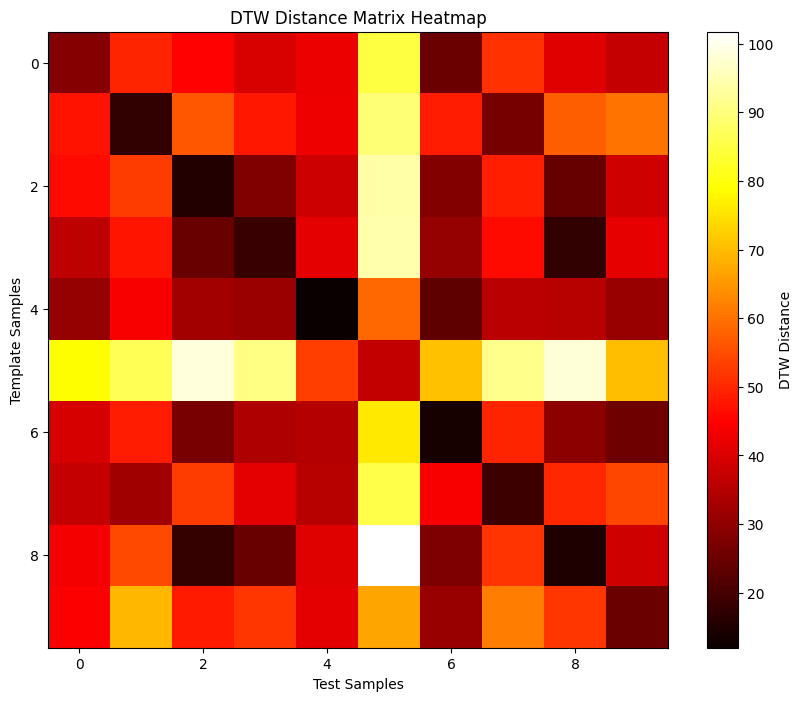

In [2]:
plot_distance_matrix(distance_matrix)

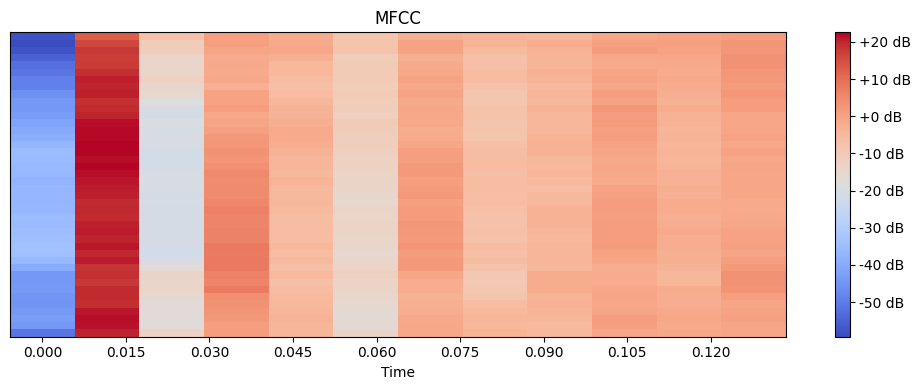

In [3]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_temp[0], x_axis='time', sr=sample_rate)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()